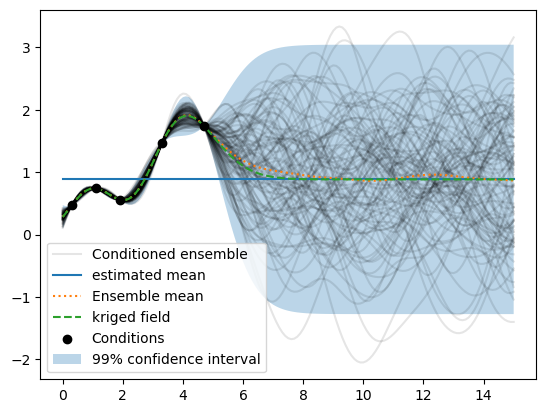

In [1]:
"""
Conditioning with Ordinary Kriging
----------------------------------

Here we use ordinary kriging in 1D (for plotting reasons)
with 5 given observations/conditions,
to generate an ensemble of conditioned random fields.
"""
import matplotlib.pyplot as plt
import numpy as np

import gstools as gs

# condtions
cond_pos = [0.3, 1.9, 1.1, 3.3, 4.7]
cond_val = [0.47, 0.56, 0.74, 1.47, 1.74]
gridx = np.linspace(0.0, 15.0, 151)

###############################################################################
# The conditioned spatial random field class depends on a Krige class in order
# to handle the conditions.
# This is created as described in the kriging tutorial.
#
# Here we use a Gaussian covariance model and ordinary kriging for conditioning
# the spatial random field.

model = gs.Gaussian(dim=1, var=0.5, len_scale=1.5)
krige = gs.krige.Ordinary(model, cond_pos, cond_val)
cond_srf = gs.CondSRF(krige)
cond_srf.set_pos(gridx)

###############################################################################
# To generate the ensemble we will use a seed-generator.
# We can specify individual names for each field by the keyword `store`:

seed = gs.random.MasterRNG(20170519)
for i in range(100):
    cond_srf(seed=seed(), store=f"f{i}")
    label = "Conditioned ensemble" if i == 0 else None
    plt.plot(gridx, cond_srf[f"f{i}"], color="k", alpha=0.1, label=label)

fields = [cond_srf[f"f{i}"] for i in range(100)]
plt.plot(gridx, cond_srf.krige(only_mean=True), label="estimated mean")
plt.plot(gridx, np.mean(fields, axis=0), linestyle=":", label="Ensemble mean")
plt.plot(gridx, cond_srf.krige.field, linestyle="dashed", label="kriged field")
plt.scatter(cond_pos, cond_val, color="k", zorder=10, label="Conditions")
# 99 percent confidence interval
conf = gs.tools.confidence_scaling(0.99)
plt.fill_between(
    gridx,
    cond_srf.krige.field - conf * np.sqrt(cond_srf.krige.krige_var),
    cond_srf.krige.field + conf * np.sqrt(cond_srf.krige.krige_var),
    alpha=0.3,
    label="99% confidence interval",
)
plt.legend()
plt.show()

###############################################################################
# As you can see, the kriging field coincides with the ensemble mean of the
# conditioned random fields and the estimated mean
# is the mean of the far-field.


/private/tmp/PKInstallSandbox.l9D2z8/tmp/ipykernel_12216/3372240865.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


['fld0', 'fld1', 'fld2', 'fld3']


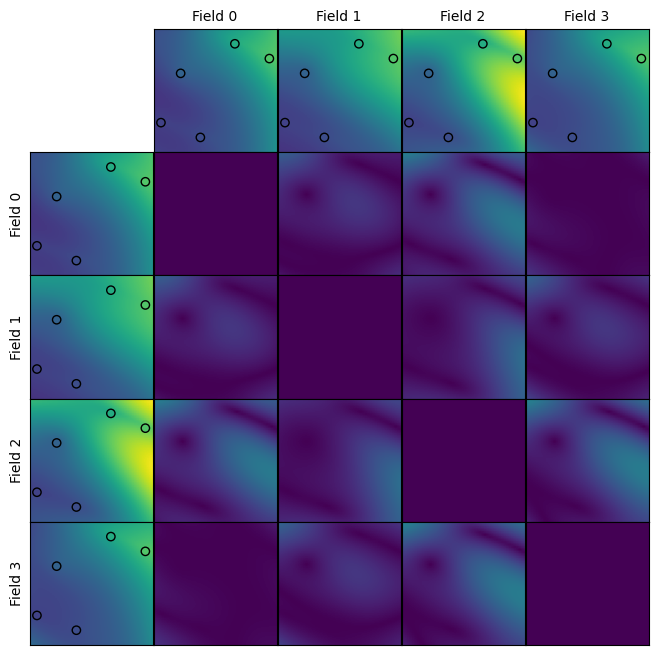

In [2]:
"""
Creating an Ensemble of conditioned 2D Fields
---------------------------------------------

Let's create an ensemble of conditioned random fields in 2D.
"""
import matplotlib.pyplot as plt
import numpy as np

import gstools as gs

# conditioning data (x, y, value)
cond_pos = [[0.3, 1.9, 1.1, 3.3, 4.7], [1.2, 0.6, 3.2, 4.4, 3.8]]
cond_val = [0.47, 0.56, 0.74, 1.47, 1.74]

# grid definition for output field
x = np.arange(0, 5, 0.1)
y = np.arange(0, 5, 0.1)

model = gs.Gaussian(dim=2, var=0.5, len_scale=5, anis=0.5, angles=-0.5)
krige = gs.Krige(model, cond_pos=cond_pos, cond_val=cond_val)
cond_srf = gs.CondSRF(krige)
cond_srf.set_pos([x, y], "structured")

###############################################################################
# To generate the ensemble we will use a seed-generator.
# By specifying ``store=[f"fld{i}", False, False]``, only the conditioned field
# is stored with the specified name. The raw random field and the raw kriging
# field is not stored. This way, we can access each conditioned field by index
# ``cond_srf[i]``:

seed = gs.random.MasterRNG(20170519)
ens_no = 4
for i in range(ens_no):
    cond_srf(seed=seed(), store=[f"fld{i}", False, False])

###############################################################################
# Now let's have a look at the pairwise differences between the generated
# fields. We will see, that they coincide at the given conditions.

fig, ax = plt.subplots(ens_no + 1, ens_no + 1, figsize=(8, 8))
# plotting kwargs for scatter and image
vmax = np.max(cond_srf.all_fields)
sc_kw = dict(c=cond_val, edgecolors="k", vmin=0, vmax=vmax)
im_kw = dict(extent=2 * [0, 5], origin="lower", vmin=0, vmax=vmax)
for i in range(ens_no):
    # conditioned fields and conditions
    ax[i + 1, 0].imshow(cond_srf[i].T, **im_kw)
    ax[i + 1, 0].scatter(*cond_pos, **sc_kw)
    ax[i + 1, 0].set_ylabel(f"Field {i}", fontsize=10)
    ax[0, i + 1].imshow(cond_srf[i].T, **im_kw)
    ax[0, i + 1].scatter(*cond_pos, **sc_kw)
    ax[0, i + 1].set_title(f"Field {i}", fontsize=10)
    # absolute differences
    for j in range(ens_no):
        ax[i + 1, j + 1].imshow(np.abs(cond_srf[i] - cond_srf[j]).T, **im_kw)

# beautify plots
ax[0, 0].axis("off")
for a in ax.flatten():
    a.set_xticklabels([]), a.set_yticklabels([])
    a.set_xticks([]), a.set_yticks([])
fig.subplots_adjust(wspace=0, hspace=0)
fig.show()

###############################################################################
# To check if the generated fields are correct, we can have a look at their
# names:

print(cond_srf.field_names)
